In [ ]:
import os
import numpy as np
from PIL import Image
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')
root_folder = '/content/drive/MyDrive'

new_folder_path = os.path.join(root_folder, 'BrainMRIs')
test_folder = os.path.join(new_folder_path, 'Test')
train_folder = os.path.join(new_folder_path, 'Train')
os.mkdir(new_folder_path)
os.mkdir(test_folder)
os.mkdir(train_folder)

# Class mapping
classes_to_i = {'glioma': 0, "meningioma": 1, "pituitary": 2, "notumor": 3}

trainNames = []
testNames = []

# Original folder path
folder_path = '/content/drive/MyDrive/archive'

for test_train in os.listdir(folder_path):
    test_train_path = os.path.join(folder_path, test_train)


    for class_name in os.listdir(test_train_path):
        class_path = os.path.join(test_train_path, class_name)

        i = 0
        for filename in os.listdir(class_path):
            old_file_path = os.path.join(class_path, filename)
            new_file_name = f"{classes_to_i[class_name]}_{i}.npy"  # Save as .npy
            if test_train == 'Testing':
                new_file_path = os.path.join(test_folder, new_file_name)
                testNames.append(new_file_name)
            else:
                new_file_path = os.path.join(train_folder, new_file_name)
                trainNames.append(new_file_name)

            # Open and preprocess image
            img = np.array(Image.open(old_file_path).convert('L').resize((256, 256), Image.BICUBIC))

            # Normalize
            maxVal = np.max(img)
            if maxVal != 0:
                img = img / maxVal

            # Flatten
            flattened_img = img.flatten()

            # Save the flattened image as a .npy file
            np.save(new_file_path, flattened_img)

            i += 1

# Final paths for reference
print(f"Train images saved to: {train_folder}")
print(f"Test images saved to: {test_folder}")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from google.colab import drive
import random
import torch.nn.functional as F

# Mount Google Drive
drive.mount('/content/drive')


# neural network architecture with BatchNorm and Dropout
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # First layer
        self.fc1 = nn.Linear(256 * 256, 2048)
        self.bn1 = nn.BatchNorm1d(2048)
        self.dropout1 = nn.Dropout(p=0.6)

        # Second layer
        self.fc2 = nn.Linear(2048, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(p=0.4)

        # Output layer
        self.fc3 = nn.Linear(256, 4)  # Output layer

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)  # Apply BatchNorm
        x = F.relu(x)  # Activation function
        x = self.dropout1(x)  # Apply Dropout

        x = self.fc2(x)
        x = self.bn2(x)  # Apply BatchNorm
        x = F.relu(x)  # Activation function
        x = self.dropout2(x)  # Apply Dropout

        x = self.fc3(x)  # Output layer
        return x

batch_size = 32
# Define a custom dataset
class BrainMRI_Dataset(Dataset):
    def __init__(self, data_folder, file_names, transform=None):
        self.data_folder = data_folder
        self.file_names = file_names
        self.transform = transform

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_folder, self.file_names[idx])
        image = np.load(file_path)
        label = int(self.file_names[idx].split('_')[0])  # Extract the label from the filename
        image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)
        return image, label


train_folder = '/content/drive/MyDrive/BrainMRIs/Train'
test_folder = '/content/drive/MyDrive/BrainMRIs/Test'
trainNames = os.listdir(train_folder)
testNames = os.listdir(test_folder)

# Data loading
train_dataset = BrainMRI_Dataset(train_folder, trainNames)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = BrainMRI_Dataset(test_folder, testNames)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Done Dataloading\n\n")


Epoch [1/20], Training Loss: 0.7288
Average Validation Loss on 256 samples: 0.4239
Epoch [2/20], Training Loss: 0.4919
Average Validation Loss on 256 samples: 0.5805
Epoch [3/20], Training Loss: 0.3934
Average Validation Loss on 256 samples: 0.3864
Epoch [4/20], Training Loss: 0.3602
Average Validation Loss on 256 samples: 0.3724
Epoch [5/20], Training Loss: 0.2765
Average Validation Loss on 256 samples: 0.2636
Epoch [6/20], Training Loss: 0.2218
Average Validation Loss on 256 samples: 0.2900
Epoch [7/20], Training Loss: 0.2142
Average Validation Loss on 256 samples: 0.2636
Epoch [8/20], Training Loss: 0.1962
Average Validation Loss on 256 samples: 0.2276
Epoch [9/20], Training Loss: 0.1511
Average Validation Loss on 256 samples: 0.3215
Epoch [10/20], Training Loss: 0.1196
Average Validation Loss on 256 samples: 0.1426
Epoch [11/20], Training Loss: 0.1087
Average Validation Loss on 256 samples: 0.2838
Epoch [12/20], Training Loss: 0.1031
Average Validation Loss on 256 samples: 0.2649
E

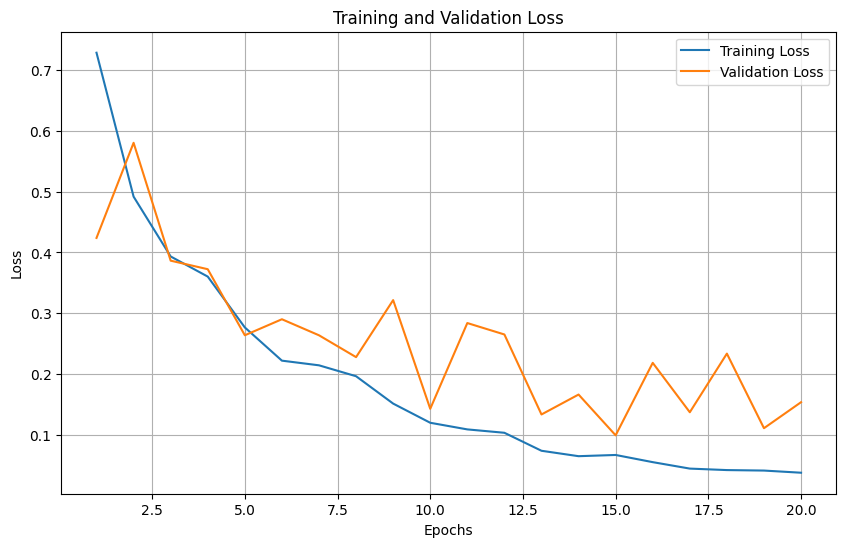

In [15]:
import random
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
learning_rate = 0.001
num_epochs = 20

# Initialize the model
model = Net().to(device)
for name, module in model.named_modules():
    if isinstance(module, nn.Linear):
        nn.init.kaiming_uniform_(module.weight, mode='fan_in', nonlinearity='relu')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.4)

# store losses
training_losses = []
validation_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    count = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward
        loss.backward()
        optimizer.step()


        running_loss += loss.item()






    # Compute average training loss for the epoch
    avg_training_loss = running_loss / len(train_loader)
    training_losses.append(avg_training_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_training_loss:.4f}')

    # Validation on random subset
    model.eval()  # Set the model to evaluation mode
    num_samples = 256
    random_indices = random.sample(range(len(test_dataset)), num_samples)
    subset_dataset = torch.utils.data.Subset(test_dataset, random_indices)
    subset_loader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=False)

    total_loss = 0
    total_samples = 0
    with torch.no_grad():
        for images, labels in subset_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)
            total_samples += labels.size(0)

    avg_val_loss = total_loss / total_samples
    validation_losses.append(avg_val_loss)
    print(f'Average Validation Loss on {num_samples} samples: {avg_val_loss:.4f}')
    scheduler.step()

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), training_losses, label="Training Loss")
plt.plot(range(1, num_epochs + 1), validation_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# Evaluation on the test set
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on the test images: {100 * correct / total}%')


Accuracy on the test images: 95.26671675432006%
